In [165]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error as mse_metric
from statsmodels.graphics.tsaplots import plot_acf

In [166]:
data_directory = '../data/experiment_small/'
data = np.load(data_directory + 'network_params/data_network.npy')
data = np.transpose(data, (1, 2, 0))
data.shape

(4, 2801, 2)

In [170]:
data_train = data[:,:-3*365,:]
data_val = data[:,-3*365:-365,:]
data_test = data[:,-365:,:]

In [175]:
data_train_diff = np.diff(data_train, axis = 1)
data_val_diff= np.diff(data_val, axis = 1)
data_test_diff = np.diff(data_test, axis = 1)

### util

In [172]:
def get_mse(forecast, true_vals):
    N, f , _ = forecast.shape
    forecast = forecast.reshape(N, f * 2)
    true_vals = true_vals.reshape(N, f * 2)
    
    return mse_metric(forecast, true_vals)

def data_slice(data, h, f):
    T = h + f
    samples = np.array([data[:,t:t + T,:] for t in range(len(data[0]) - T + 1)])
    return samples[:, :, :h, :], samples[:, : , h:, :]

### Zero order hold forecaster

In [173]:
def get_ZOH_forecast(history, f=1):
    forecast = np.tile(history[:, -1:, :], (1, f, 1))
    return forecast

def get_ZOH_forecast_rmse(hists, futures):
    _,_,f,_ = futures.shape
    forecasts = np.array([get_ZOH_forecast(hist, f=f) for hist in hists])
    mse = np.mean([get_mse(forecasts[i], futures[i]) for i in range(len(futures))])
    return np.sqrt(mse)

In [174]:
h, f = 1, 7
hist_val, future_val = data_slice(data_val, h = h, f = f)
print(get_ZOH_forecast_rmse(hist_val, future_val))

4.116178683257241


### hist mean forecast

In [139]:
def get_histmean_forecast(history, f = 1):
    mean = np.mean(history, axis = 1, keepdims = True)
    forecast = np.tile(mean, (1, f, 1))
    return forecast

def get_histmean_forecast_rmse(hists, futures):
    _,_,f,_ = futures.shape
    forecasts = np.array([get_histmean_forecast(hist, f=f) for hist in hists])
    mse = np.mean([get_mse(forecasts[i], futures[i]) for i in range(len(futures))])
    return np.sqrt(mse)


def histmean_hyperparam_search(data_train, data_val, h_range, f=3):
    val_rmses = []
    for h in h_range:
        hist_val, future_val = data_slice(data_val, h = h, f = f)
        val_rmses += [get_histmean_forecast_rmse(hist_val, future_val)]
    return val_rmses

In [142]:
f = 7
h_vals = np.arange(1,50)
hist_val, future_val = data_slice(data_val, h = h, f = f)
rmses = histmean_hyperparam_search(data_train, data_val, h_vals, f=f)

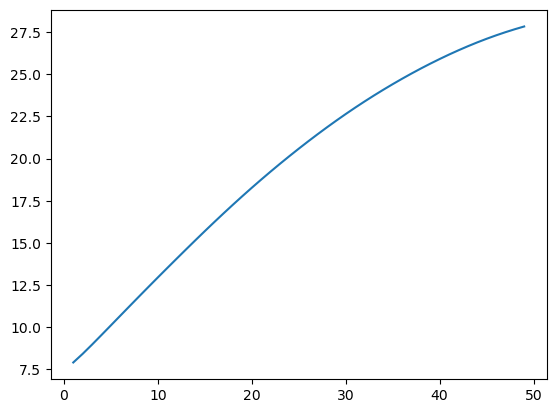

In [143]:
plt.plot(h_vals, rmses)

### lin reg forecaster

In [56]:
def linreg_joint_forecast(data_true, h = 3, w = 7): 
    n = len(data_true)
    forecast = np.zeros((n, h, 2))
    time_horizon = np.array([[x] for x in np.arange(1,h+1)])
    lin_model = linear_model.LinearRegression()
    
    for i in range(n):

        if (i < w ):
            time_hist_window  = np.array([[x] for x in np.arange(-i,1)])
        else: 
            time_hist_window = np.array([[x] for x in np.arange(-w+1,1)])

        history = data_true[max(0, i - w + 1):i + 1]

        lin_model.fit(time_hist_window, history)
        forecast[i] = lin_model.predict(time_horizon)
    return forecast   

In [57]:
num = 50
w_arr = np.arange(1,num)
data_forecast__arr = []
data_forecast_linreg_arr = []
data_forecast_linreg_joint_arr = []
for w in w_arr:
    data_forecast_linreg_joint_arr.append(error(data_true,linreg_joint_forecast(data_true,h=3,w=w)))
    
plt.plot(w_arr,data_forecast_linreg_joint_arr, label = 'joint')
plt.legend()

NameError: name 'error' is not defined